# Vehicle Detection Project

This project uses Yolov2 to detect vechicles by keras.

## Import Packages

In [1]:
import argparse
import configparser
import io
import os
from collections import defaultdict
import colorsys
import random
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob

from keras import backend as K
from keras.layers import (Conv2D, GlobalAveragePooling2D, Input, Lambda,
                          MaxPooling2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot
from keras.models import load_model


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Global variables

yolov2 config file can get from https://github.com/pjreddie/darknet/blob/master/cfg/yolov2.cfg

yolov2 wights file can get from https://pjreddie.com/media/files/yolov2.weights

In [2]:
config_path = 'yolov2.cfg'
# config_path = 'yolov3.cfg'

output_root = 'model_data/yolo.h5'

weights_path = 'yolov2.weights'
# weights_path = 'yolov3.weights'

classes_path='model_data/coco_classes.txt'
anchors_path='model_data/yolo_anchors.txt'

## Cfg File Parse

In [3]:
def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream

In [4]:
print('Parsing Darknet config.')
unique_config_file = unique_config_sections(config_path)
cfg_parser = configparser.ConfigParser()
cfg_parser.read_file(unique_config_file)

print(cfg_parser.sections())

Parsing Darknet config.
['net_0', 'convolutional_0', 'maxpool_0', 'convolutional_1', 'maxpool_1', 'convolutional_2', 'convolutional_3', 'convolutional_4', 'maxpool_2', 'convolutional_5', 'convolutional_6', 'convolutional_7', 'maxpool_3', 'convolutional_8', 'convolutional_9', 'convolutional_10', 'convolutional_11', 'convolutional_12', 'maxpool_4', 'convolutional_13', 'convolutional_14', 'convolutional_15', 'convolutional_16', 'convolutional_17', 'convolutional_18', 'convolutional_19', 'route_0', 'convolutional_20', 'reorg_0', 'route_1', 'convolutional_21', 'convolutional_22', 'region_0']


# weights

In [5]:
# Load weights and config.
print('Loading weights.')
weights_file = open(weights_path, 'rb')
weights_header = np.ndarray(
    shape=(4, ), dtype='int32', buffer=weights_file.read(16))
print('Weights Header: ', weights_header)

Loading weights.
Weights Header:  [       0        1        0 32013312]


# Construct the network

In [6]:
def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2)


def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.

    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

In [7]:
print('Creating Keras model.')
weights_file.seek(16)
image_height = int(cfg_parser['net_0']['height'])
image_width = int(cfg_parser['net_0']['width'])

prev_layer = Input(shape=(image_height, image_width, 3))
all_layers = [prev_layer]

weight_decay = float(cfg_parser['net_0']['decay']) if 'net_0' in cfg_parser.sections() else 5e-4

count = 0
for section in cfg_parser.sections():
    print('Parsing section {}'.format(section))
    if section.startswith('convolutional'):
#         [convolutional]
#         batch_normalize=1
#         filters=32
#         size=3
#         stride=1
#         pad=1
#         activation=leaky
        batch_normalize = 'batch_normalize' in cfg_parser[section]
        filters = int(cfg_parser[section]['filters'])
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        pad = int(cfg_parser[section]['pad'])
        activation = cfg_parser[section]['activation']
        
        # padding='same' is equivalent to Darknet pad=1
        padding = 'same' if pad == 1 else 'valid'

        # Setting weights.
        # Darknet serializes convolutional weights as:
        # [bias/beta, [gamma, mean, variance], conv_weights]
        prev_layer_shape = K.int_shape(prev_layer)

        # TODO: This assumes channel last dim_ordering.
        weights_shape = (size, size, prev_layer_shape[-1], filters)
        darknet_w_shape = (filters, weights_shape[2], size, size)
        weights_size = np.product(weights_shape)

#         print('conv2d', 'bn'
#               if batch_normalize else '  ', activation, weights_shape)

        conv_bias = np.ndarray(shape=(filters, ),dtype='float32',buffer=weights_file.read(filters * 4))
        count += filters

        if batch_normalize:
            bn_weights = np.ndarray(shape=(3, filters),dtype='float32',buffer=weights_file.read(filters * 12))
            count += 3 * filters

            # TODO: Keras BatchNormalization mistakenly refers to var
            # as std.
            bn_weight_list = [
                bn_weights[0],  # scale gamma
                conv_bias,  # shift beta
                bn_weights[1],  # running mean
                bn_weights[2]  # running var
            ]

        conv_weights = np.ndarray(shape=darknet_w_shape,dtype='float32',buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet conv_weights are serialized Caffe-style:
        # (out_dim, in_dim, height, width)
        # We would like to set these to Tensorflow order:
        # (height, width, in_dim, out_dim)
        # TODO: Add check for Theano dim ordering.
        conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
        conv_weights = [conv_weights] if batch_normalize else [conv_weights, conv_bias]

        # Handle activation.
        act_fn = None
        if activation == 'leaky':
            pass  # Add advanced activation later.
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        # Create Conv2D layer
        conv_layer = (Conv2D(filters, (size, size),strides=(stride, stride),kernel_regularizer=l2(weight_decay),\
            use_bias=not batch_normalize,weights=conv_weights,activation=act_fn,padding=padding))(prev_layer)

        if batch_normalize:
            conv_layer = (BatchNormalization(weights=bn_weight_list))(conv_layer)
        prev_layer = conv_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('maxpool'):
#         [maxpool]
#         size=2
#         stride=2
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        all_layers.append(MaxPooling2D(padding='same',pool_size=(size, size),strides=(stride, stride))(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('avgpool'):
        if cfg_parser.items(section) != []:
            raise ValueError('{} with params unsupported.'.format(section))
        all_layers.append(GlobalAveragePooling2D()(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('route'):
#         [route]
#         layers=-9
        ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
        layers = [all_layers[i] for i in ids]
        if len(layers) > 1:
            print('Concatenating route layers:', layers)
            concatenate_layer = concatenate(layers)
            all_layers.append(concatenate_layer)
            prev_layer = concatenate_layer
        else:
            skip_layer = layers[0]  # only one layer to route
            all_layers.append(skip_layer)
            prev_layer = skip_layer

    elif section.startswith('reorg'):
        block_size = int(cfg_parser[section]['stride'])
        assert block_size == 2, 'Only reorg with stride 2 supported.'
        all_layers.append(
            Lambda(space_to_depth_x2,output_shape=space_to_depth_x2_output_shape,name='space_to_depth_x2')(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('region'):
        with open('{}_anchors.txt'.format(output_root), 'w') as f:
            print(cfg_parser[section]['anchors'], file=f)

    elif (section.startswith('net') or section.startswith('cost') or
          section.startswith('softmax')):
        pass  # Configs not currently handled during model definition.

    else:
        raise ValueError(
            'Unsupported section header type: {}'.format(section))

# Create and save model.
model = Model(inputs=all_layers[0], outputs=all_layers[-1])

model.save('{}'.format(output_root))
print('Saved Keras model to {}'.format(output_root))
# Check to see if all weights have been read.
remaining_weights = len(weights_file.read()) / 4
# weights_file.close()
print('Read {} of {} from Darknet weights.'.format(count, count + remaining_weights))

print("Construction Done!")

Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
Parsing section maxpool_0
Parsing section convolutional_1
Parsing section maxpool_1
Parsing section convolutional_2
Parsing section convolutional_3
Parsing section convolutional_4
Parsing section maxpool_2
Parsing section convolutional_5
Parsing section convolutional_6
Parsing section convolutional_7
Parsing section maxpool_3
Parsing section convolutional_8
Parsing section convolutional_9
Parsing section convolutional_10
Parsing section convolutional_11
Parsing section convolutional_12
Parsing section maxpool_4
Parsing section convolutional_13
Parsing section convolutional_14
Parsing section convolutional_15
Parsing section convolutional_16
Parsing section convolutional_17
Parsing section convolutional_18
Parsing section convolutional_19
Parsing section route_0
Parsing section convolutional_20
Parsing section reorg_0
Parsing section route_1
Concatenating route layers: [<tf.Tensor 'space_to_depth_x2/SpaceToDepth

In [8]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 480, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 480, 480, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 480, 480, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## Classes and Anchors

In [9]:
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

print("classes:")
print((class_names))

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

print("anchors:")
print((anchors))    

classes:
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
anchors:
[[ 0.57273   0.677385]
 [ 1.87446   2.06253 ]
 [ 3.33843   5.47434 ]
 [ 7.88282   3.52778 ]
 [ 9.77052   9.16828 ]]


## Load model

In [10]:
yolo_model = load_model(output_root)
# yolo_model = model

d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
model_image_size = yolo_model.layers[0].input_shape[1:3]
print("Network input shape:")
print(model_image_size)

Network input shape:
(480, 480)


## Preditct

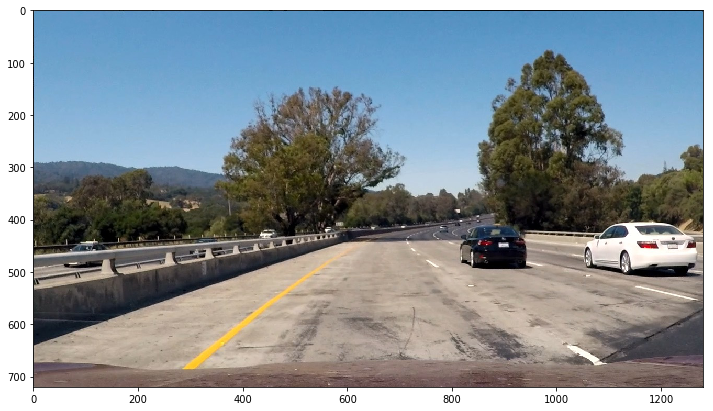

In [12]:
orig_images = mpimg.imread('test_images/test1.jpg')
fig = plt.figure(figsize=(12, 12))
plt.imshow(orig_images)

In [13]:
image_data = cv2.resize(orig_images, (image_height,image_width))
image_data = image_data/255.0
image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

predicts = yolo_model.predict(image_data)
print("preditct shape")
print(predicts.shape)
res = np.reshape(predicts,(predicts.shape[1],predicts.shape[2],len(anchors),5+len(class_names)))
print("reshape size")
print(res.shape)

preditct shape
(1, 15, 15, 425)
reshape size
(15, 15, 5, 85)


## fcuntion definiton

In [14]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [15]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3   

def converxywh_to_xycoord(box):
    x, y, w, h = box[:4]
    x_min,x_max,y_min,y_max = x - w/2.0,x + w/2.0,y - h/2.0,y + h/2.0
    
    return x_min,x_max,y_min,y_max

def area(box):
    x, y, w, h = box[:4]
    return (w*h)
    

def nms_iou(box1,box2):
    x1_min,x1_max,y1_min,y1_max = converxywh_to_xycoord(box1)
    x2_min,x2_max,y2_min,y2_max = converxywh_to_xycoord(box2)
    
    intersect_w = _interval_overlap([x1_min,x1_max], [x2_min, x2_max])
    intersect_h = _interval_overlap([y1_min, y1_max], [y2_min, y2_max])
    
    intersect = intersect_w * intersect_h
    
    union = area(box1) + area(box2)- intersect
    
    return float(intersect) / union

In [16]:
def decode_netout(networkouput, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3,filtered = True):
    
    netout = networkouput.copy()
    
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold

    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
               
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[b,0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[b,1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]

                    classes = netout[row,col,b,5:]
                    boxes.append([x, y, w, h,confidence,classes])

     # suppress non-maximal boxes
    if filtered:
        for c in range(nb_class):
            sorted_indices = list(reversed(np.argsort([box[5][c] for box in boxes])))

            for i in range(len(sorted_indices)):
                index_i = sorted_indices[i]

                if boxes[index_i][5][c] == 0: 
                    continue
                else:
                    for j in range(i+1, len(sorted_indices)):
                        index_j = sorted_indices[j]

                        if nms_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                            boxes[index_j][5][c] = 0

        # remove the boxes which are less likely than a obj_threshold
        boxes = [box for box in boxes if box[5][(np.argmax(box[5:]))] > obj_threshold]
    
    return boxes    

## Show Results

In [17]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),colors))
    
    return colors

### Show all detected results

results show:
original boxes:
67 439 141 475 car:35.4%
810 413 938 495 car:85.6%
1046 405 1260 509 car:90.0%


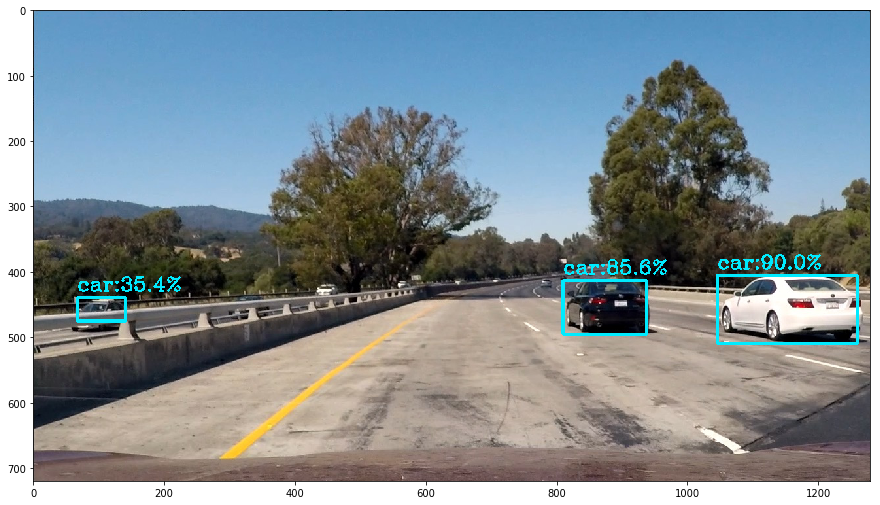

In [18]:
print("results show:")
fig = plt.figure(figsize=(15, 15))
show_images = np.copy(orig_images)
colors = random_colors(len(class_names))

print("original boxes:")
result = decode_netout(res,anchors,len(class_names),filtered = False)
for i,predits in enumerate(result):
    x, y, w, h,confidence,classone = predits
    classone = np.argmax(classone)
    
    #coordinate converation
    x = x *  model_image_size[1] * (orig_images.shape[1] / model_image_size[1])
    y = y *   model_image_size[0] * (orig_images.shape[0] / model_image_size[0])
    w = w *   model_image_size[1] * (orig_images.shape[1] / model_image_size[1])
    h = h *  model_image_size[0] * (orig_images.shape[0] / model_image_size[0])

    xmin = int(x - w/2.0)
    xmax = int(x + w/2.0)
    ymin = int(y - h/2.0)
    ymax = int(y + h/2.0)
    
    color = colors[int(classone)]
    
    label = '{}:{:.1f}%'.format(class_names[classone],confidence*100)
    print(xmin,ymin,xmax,ymax,label)
    
    cv2.rectangle(show_images,(xmin,ymin),(xmax,ymax),color, 3)
    cv2.putText(show_images,label,(xmin,ymin-10),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
    plt.imshow(show_images)

## Non-maximal suppress results

suppress non-maximal boxes:
67 439 141 475 car:35.4%
810 413 938 495 car:85.6%
1046 405 1260 509 car:90.0%


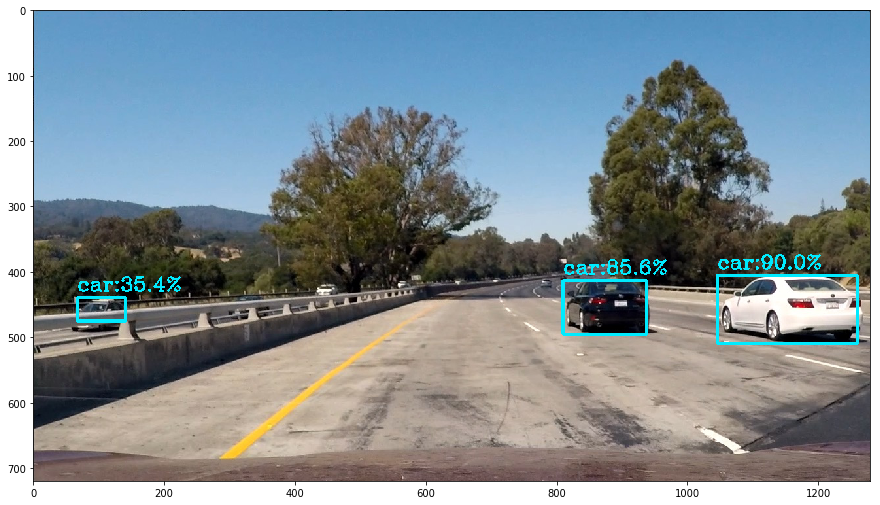

In [19]:
print("suppress non-maximal boxes:")
fig = plt.figure(figsize=(15, 15))
result = decode_netout(res,anchors,len(class_names),filtered = True)
show_images = np.copy(orig_images)

for i,predits in enumerate(result):
    x, y, w, h,confidence,classone = predits
    classone = np.argmax(classone)
    
    x = x *  model_image_size[1] * (orig_images.shape[1] / model_image_size[1])
    y = y *   model_image_size[0] * (orig_images.shape[0] / model_image_size[0])
    w = w *   model_image_size[1] * (orig_images.shape[1] / model_image_size[1])
    h = h *  model_image_size[0] * (orig_images.shape[0] / model_image_size[0])

    xmin = int(x - w/2.0)
    xmax = int(x + w/2.0)
    ymin = int(y - h/2.0)
    ymax = int(y + h/2.0)
    
    color = colors[int(classone)]
    
    label = '{}:{:.1f}%'.format(class_names[classone],confidence*100)
    print(xmin,ymin,xmax,ymax,label)
    
    cv2.rectangle(show_images,(xmin,ymin),(xmax,ymax),color, 3)
    cv2.putText(show_images,label,(xmin,ymin-10),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
    plt.imshow(show_images)

## function Combined

In [20]:
class Vechiledectect():
    def __init__(self,anchors,class_names):
        
        self.model = load_model(output_root)
        self.anchors = anchors
        self.class_names = class_names
        self.colors = random_colors(len(self.class_names))
        
    def vechile_find(self,image,debugcombined = True,framenumber = None):
        
        image_height,image_width = yolo_model.layers[0].input_shape[1:3]
        
        image_data = cv2.resize(image, (image_height,image_width))
        image_data = image_data/255.0
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        predicts = self.model.predict(image_data)
        res = np.reshape(predicts,(predicts.shape[1],predicts.shape[2],len(self.anchors),5+len(self.class_names)))
        
        result = decode_netout(res,self.anchors,len(self.class_names),filtered = True)
        
        show_images = np.copy(image)
        
        for i,predits in enumerate(result):
            x, y, w, h,confidence,classone = predits
            classone = np.argmax(classone)

            x = x *  model_image_size[1] * (image.shape[1] / model_image_size[1])
            y = y *   model_image_size[0] * (image.shape[0] / model_image_size[0])
            w = w *   model_image_size[1] * (image.shape[1] / model_image_size[1])
            h = h *  model_image_size[0] * (image.shape[0] / model_image_size[0])

            xmin = int(x - w/2.0)
            xmax = int(x + w/2.0)
            ymin = int(y - h/2.0)
            ymax = int(y + h/2.0)

            color = self.colors[int(classone)]

            label = '{}:{:.1f}%'.format(self.class_names[classone],confidence*100)

            cv2.rectangle(show_images,(xmin,ymin),(xmax,ymax),color, 3)
            cv2.putText(show_images,label,(xmin,ymin-10),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
        
        return show_images

d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


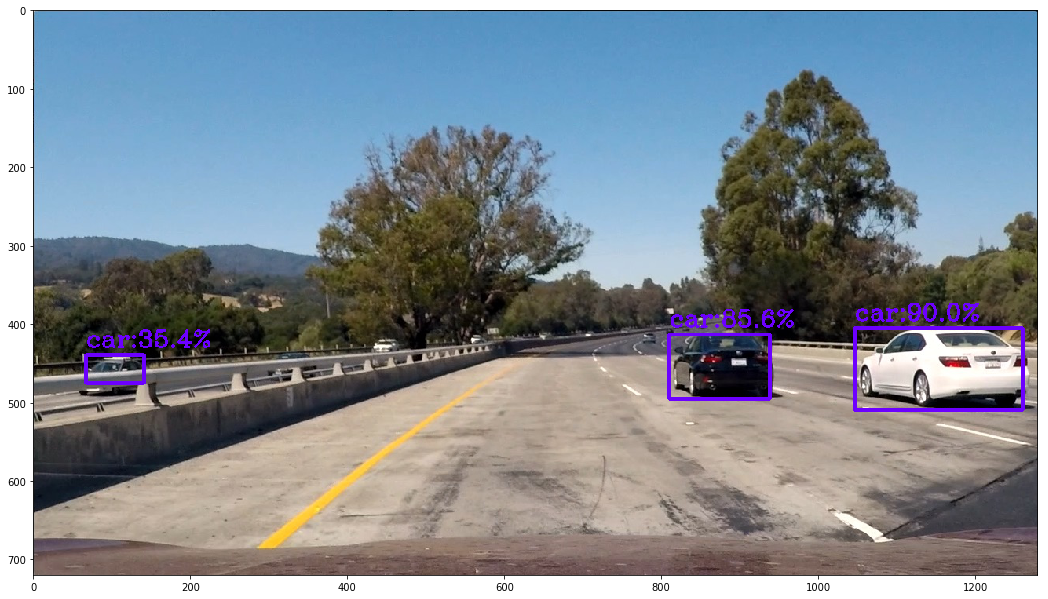

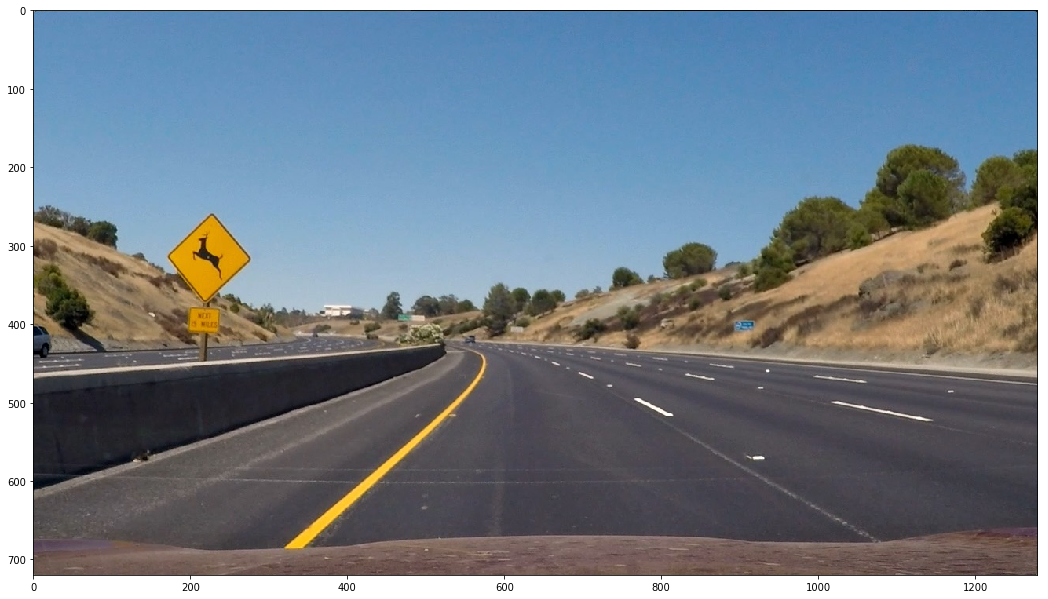

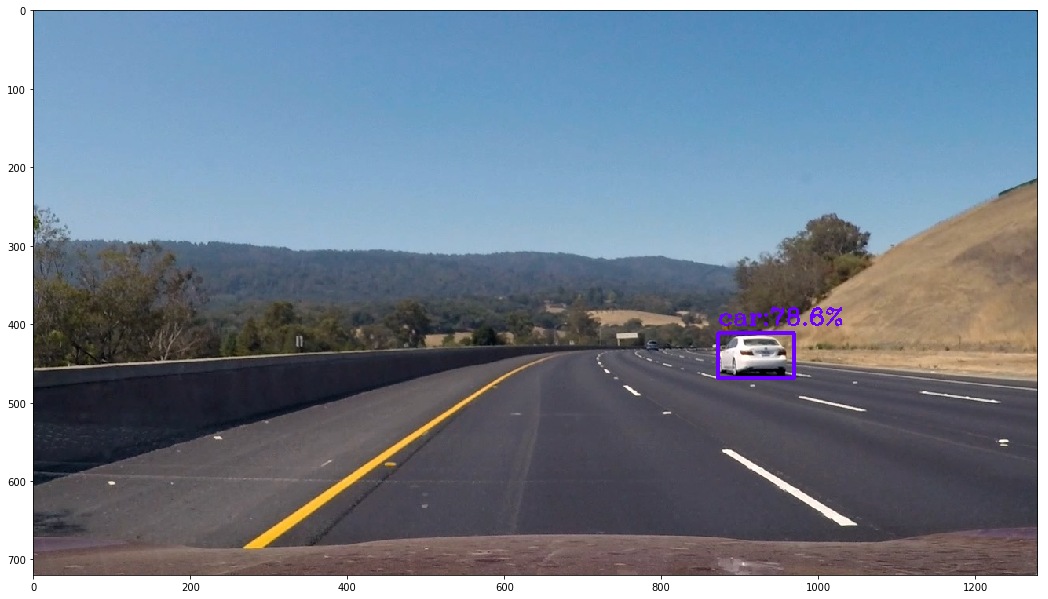

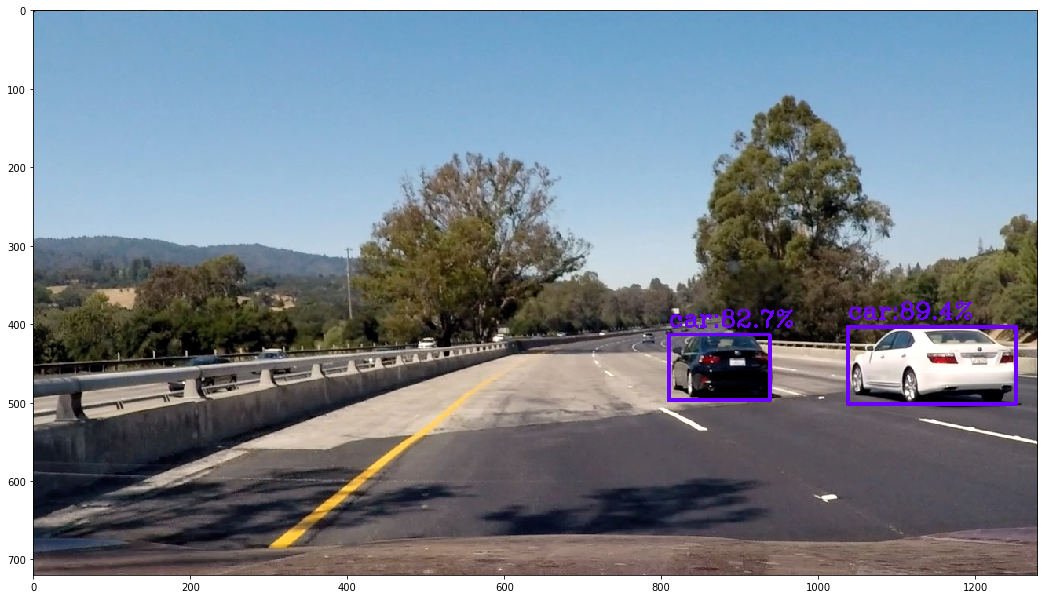

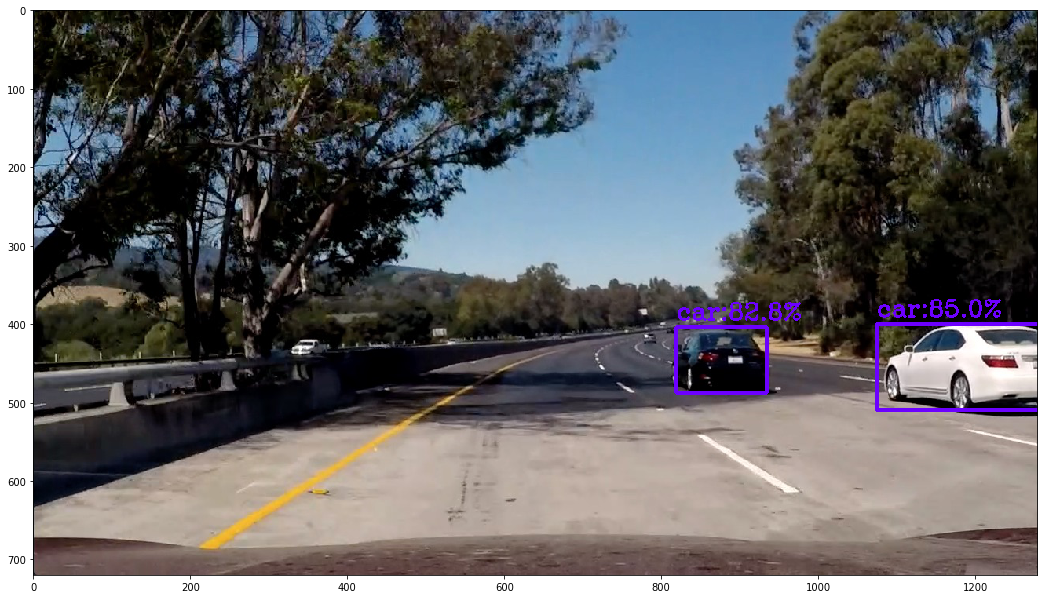

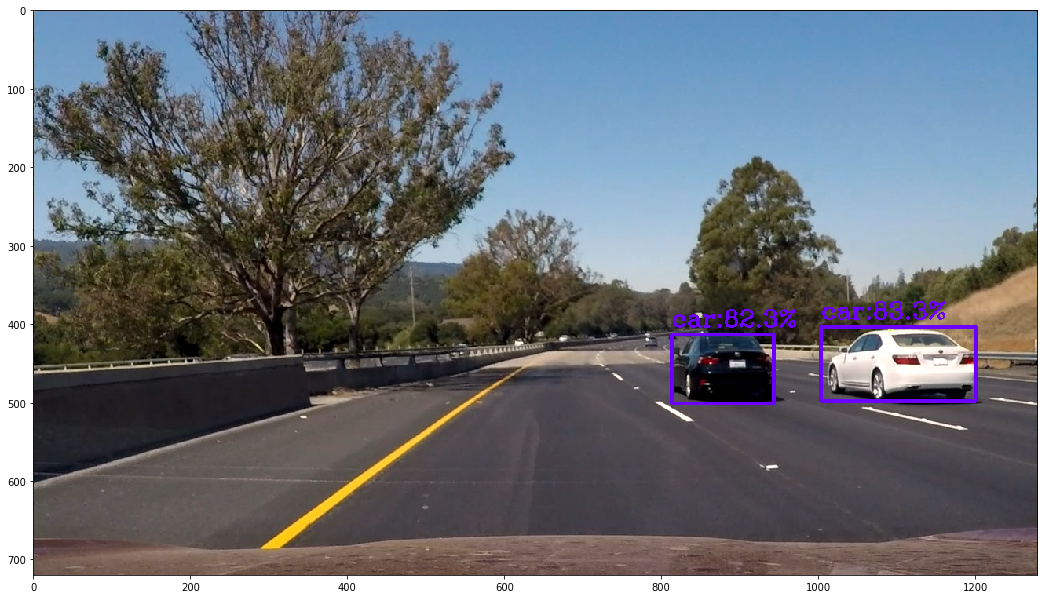

In [21]:
L = Vechiledectect(anchors=anchors,class_names=class_names)


test_images = [plt.imread(path) for path in glob.glob('test_images/test*.jpg')]

for i, image in enumerate(test_images):
    vechilefinds = L.vechile_find(image)

    fig = plt.figure(figsize=(18, 18))
    plt.imshow(vechilefinds)

## Test on Videos

### Real time detection

In [23]:
import cv2
import time

video_source = "test_videos/project_video.mp4"

cap = cv2.VideoCapture(video_source)

count = 0

while True:
    ret, frame = cap.read()
    if ret == True:
        start = time.time()
        
        vechilefinds = L.vechile_find(frame)
        
        done = time.time()
        elapsed = done - start
        if elapsed !=0:
            fps = 1.0/elapsed
        frame_label = 'Fps:{:.1f}'.format(fps)
        
        cv2.putText(vechilefinds,frame_label,(0, 30),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),1)
        
        cv2.imshow('video', vechilefinds)
    else:
        break
        
    if cv2.waitKey(1) & 0xff == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() 

### video detection

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_source = "test_videos/project_video.mp4"
project_output = "test_videos_output/project_video_output.mp4"


## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# L = Vechiledectect()

clip1 = VideoFileClip(project_source)
line_clip = clip1.fl_image(L.vechile_find) #NOTE: this function expects color images!!
%time line_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [00:53<00:00, 23.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 53.9 s


In [27]:
HTML("""
<video width="1080" height="640" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [28]:
line_clip.resize(height=360).speedx(5).to_gif('resources/project.gif')


[MoviePy] Building file resources/project.gif with imageio


100%|█████████▉| 252/253 [00:28<00:00,  9.23it/s]


![](resources/project.gif)